### Loading all the required modules

In [47]:
import data_preprocessing
import model
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from string import punctuation

### Preprocessing the data

In [48]:
(data, vocab_size, tokenized_text, features) = data_preprocessing.load_data()
data

array([[   0,    0,    0, ...,    0,    1,  683],
       [   0,    0,    0, ...,    1,  683,    4],
       [   0,    0,    0, ...,  683,    4,   45],
       ...,
       [   0,    0,    0, ...,    4,   45, 1042],
       [   0,    0,    0, ...,   45, 1042,    4],
       [   0,    0,    0, ..., 1042,    4,  192]], shape=(25613, 14))

### Making the x, Y split

In [49]:
y = data[:, -1]
x = data[:, :-1]


### Hyperparameters

In [50]:
input_size = 128
hidden_size = 256
num_layers = 1
num_classes = vocab_size
learning_rate = 0.001
batch_size = 64
num_epochs = 60
sequence_length = 1

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [52]:
train_data = TensorDataset(torch.from_numpy(x), torch.from_numpy(y))

In [53]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle = True)

### Model instance and defining loss and optimizer

In [54]:
model_instance = model.LSTM(input_size, hidden_size, num_layers, num_classes, sequence_length, vocab_size).to(device)

In [55]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_instance.parameters(), lr = learning_rate, weight_decay=1e-5)

### Training the model

In [56]:
train_acc = []

for epoch in range(num_epochs):

    train_losses = []

    print(f"Training for epoch :- {epoch+1}/{num_epochs}")
    for batch_idx, (data, targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = targets.to(device).long()

        scores = model_instance(data)
        loss_value = loss(scores, targets)

        optimizer.zero_grad()
        loss_value.backward()

        optimizer.step()

    num_correct = num_samples = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = targets.to(device).long()

        scores = model_instance(data)
        loss_value = loss(scores, targets)
        _, predictions = scores.max(1)

        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
        
        train_losses.append(loss_value.item())
    print(f"Loss : {np.mean(train_losses)}")

    train_acc.append(float(num_correct)/float(num_samples)*100)

    print(f"Accuracy :- {float(num_correct)/float(num_samples)*100}")

Training for epoch :- 1/60
Loss : 6.073537945450095
Accuracy :- 7.929567016749307
Training for epoch :- 2/60
Loss : 5.530752943043697
Accuracy :- 9.760668410572757
Training for epoch :- 3/60
Loss : 4.989616084871744
Accuracy :- 11.607386873853121
Training for epoch :- 4/60
Loss : 4.423710452648172
Accuracy :- 14.984578143911294
Training for epoch :- 5/60
Loss : 3.8843789885466236
Accuracy :- 22.246515441377426
Training for epoch :- 6/60
Loss : 3.3812775558367036
Accuracy :- 30.769531097489555
Training for epoch :- 7/60
Loss : 2.9462942262540137
Accuracy :- 38.65224690586812
Training for epoch :- 8/60
Loss : 2.5738880557015054
Accuracy :- 45.16846913676649
Training for epoch :- 9/60
Loss : 2.285377708456463
Accuracy :- 51.25522195759966
Training for epoch :- 10/60
Loss : 2.0463359647260937
Accuracy :- 56.49474876039511
Training for epoch :- 11/60
Loss : 1.8418939601156183
Accuracy :- 60.3170265099754
Training for epoch :- 12/60
Loss : 1.6658700749166588
Accuracy :- 64.11587865537032
Tra

### Graph for Accuracy vs Epochs

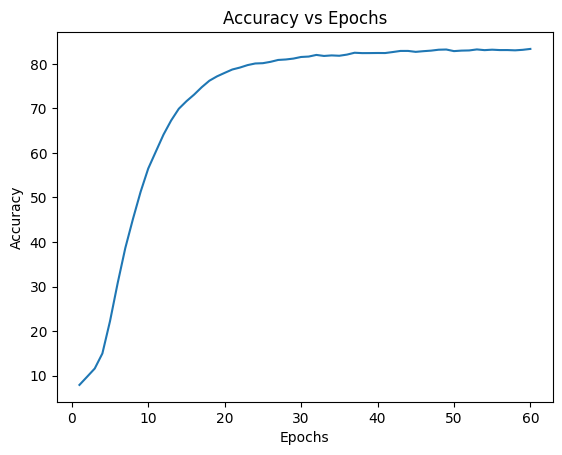

In [57]:
plt.plot(range(1, num_epochs+1), train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()

### Defining function for prediction

In [62]:
def prediction(sentence, num_words):
    for i in range(num_words):
        final_sentence = sentence
        sentence = ''.join(c.lower() for c in sentence if c not in punctuation)
        sentence_split = sentence.split(' ')
        sentence_split = [word for word in sentence_split if word != '']
        sentence_tokenized = []
        for word in sentence_split:
            sentence_tokenized.append(tokenized_text[word])
        sentence_padded = np.zeros(features-1, dtype=int)
        sentence_padded[features-len(sentence_tokenized)-1:] = np.array(sentence_tokenized)
        test = torch.Tensor(sentence_padded).unsqueeze(0).to(int)
        test = test.to(device)
        scores = model_instance(test)
        _, pred = scores.max(1)
        for word, token in tokenized_text.items():
            if token == pred:
                final_sentence += ' '
                final_sentence += word
                sentence = final_sentence
                break
    return sentence

### Predicting for single sentences

In [63]:
sentence = "you come most"
num_words = 1
pred = prediction(sentence, num_words)
print(pred)

you come most carefully


In [64]:
sentence = "god blesse"
num_words = 2
pred = prediction(sentence, num_words)
print(pred)

god blesse you sir


In [65]:
sentence = "The Tragedie of Hamlet"
num_words = 4
pred = prediction(sentence, num_words)
print(pred)

The Tragedie of Hamlet by william shakespeare 1599
